# Practical Application Assignment 17.1: Comparing Classifiers to Predict Success of Marketing Campaign

## Data

In [509]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from scipy.stats.mstats import winsorize

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector

import warnings
warnings.filterwarnings(action= 'ignore')

import pickle

In [510]:
data = pd.read_csv("data/bank-full.csv", sep= ";")
# data = pd.read_csv("data/bank.csv", sep= ";") # import part dataset of exploratory data analysis
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [511]:
data['y'].value_counts(normalize= True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

## Exploratory Data Analysis

1. The probability of a customer subscribing to a term deposit goes down as the number of contacts performed during this campaign increases.

In [512]:
# calculate custom buckets for time since last contact
# data.drop(['time_since_last_contact'], axis= 1, inplace= True)
data.loc[(data.pdays >= 0) & (data.pdays < 90), "time_since_last_contact"] = "<3 M"
data.loc[(data.pdays >= 91) & (data.pdays < 180), "time_since_last_contact"] = "3-6 M"
data.loc[(data.pdays >= 181) & (data.pdays < 365), "time_since_last_contact"] = "6M - 1Y"
data.loc[(data.pdays >= 266) & (data.pdays < 99999), "time_since_last_contact"] = ">1 Y"
data['time_since_last_contact'] = data['time_since_last_contact'].fillna('NA')

In [513]:
# function to calculate probability of success
calc_success_rate = lambda x: (x=="yes").sum()/len(x)

# winsorize some of the numerical data
data['balance'] = winsorize(data['balance'], (0.02, 0.025))
data['campaign'] = winsorize(data['campaign'], (0, 0.015)).astype(int)

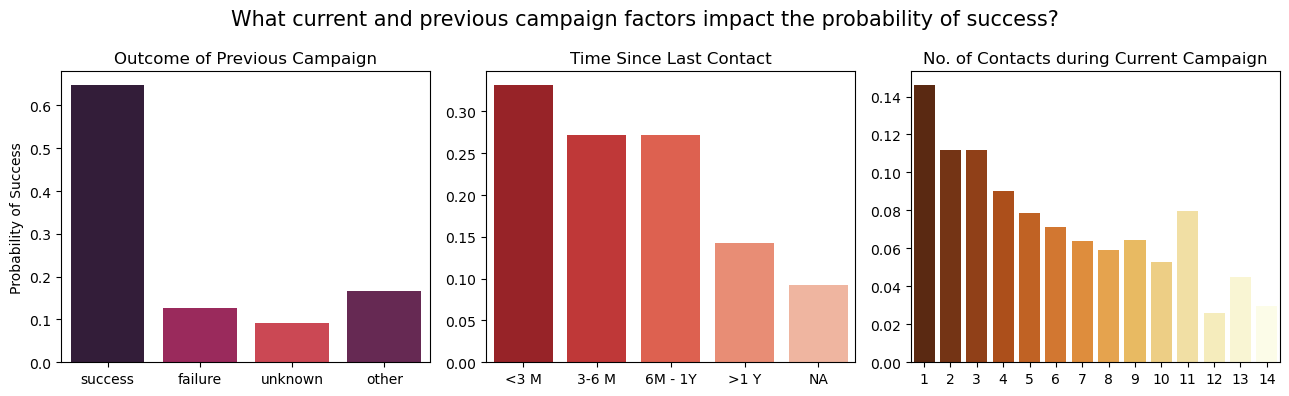

In [514]:
fig,axs = plt.subplots(figsize= (13,4), ncols= 3)

sns.barplot(data= data.groupby('poutcome')['y'].agg(calc_success_rate).reset_index(), x= "poutcome", y= "y", legend= False,
            ax= axs[0], palette= sns.color_palette("rocket"), hue= "poutcome", hue_order= ["unknown","failure", "other", "success"][::-1],
            order= ["success", "failure", "unknown", "other"])
axs[0].set_title("Outcome of Previous Campaign")
axs[0].xaxis.label.set_visible(False)
axs[0].set_ylabel("Probability of Success")


sns.barplot(data= data.groupby('time_since_last_contact')['y'].agg(calc_success_rate).reset_index(), 
            x= "time_since_last_contact", y= "y", legend= False, order= ["<3 M","3-6 M", "6M - 1Y", ">1 Y", "NA"],
            hue_order= ["<3 M","3-6 M", "6M - 1Y", ">1 Y", "NA"],
            ax= axs[1], palette= sns.color_palette('Reds_r'), hue= "time_since_last_contact")
axs[1].set_title("Time Since Last Contact")
axs[1].xaxis.label.set_visible(False)
axs[1].yaxis.label.set_visible(False)


sns.barplot(data= data.groupby('campaign')['y'].agg(calc_success_rate).reset_index(), x= "campaign", y= "y", legend= False,
            ax= axs[2], palette= sns.color_palette('YlOrBr_r', as_cmap= True), hue= "campaign")
axs[2].set_title("No. of Contacts during Current Campaign")
axs[2].xaxis.label.set_visible(False)
axs[2].yaxis.label.set_visible(False)


plt.suptitle("What current and previous campaign factors impact the probability of success?", fontsize= 15)
plt.tight_layout();
fig.savefig("images/previous_current_campaign.png")

#### How does timing of contact impact probability of success?

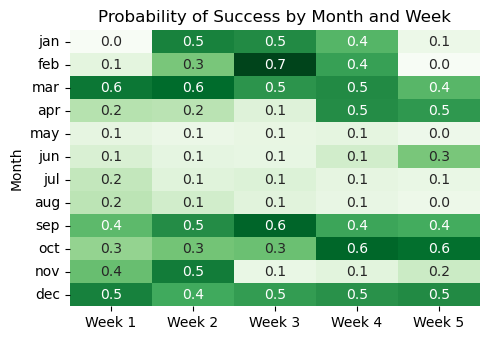

In [515]:
data['week_no'] =  'Week ' + (1+np.floor(data.day/7)).astype(int).astype(str)

plt.figure(figsize= (5,3.5))
sns.heatmap(pd.pivot_table(data= data, index= "month", columns= "week_no", values= 'y', aggfunc= calc_success_rate).\
            fillna(0).T.sort_index()[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']].T, 
            annot= True, cbar= False, cmap = sns.color_palette("Greens", as_cmap= True), fmt= "0.1f")
plt.xlabel('')
plt.ylabel("Month")
plt.title("Probability of Success by Month and Week")
plt.tight_layout();
plt.savefig("images/by_time_of_contact.png")

### How does demographic information impact the probability of success?

1. Demographics
2. Financial Information

In [516]:
data.loc[data.age<25, "age_group"] = "18-24"
data.loc[(data.age>=25) & (data.age<30), "age_group"] = "25-30"
data.loc[(data.age>=30) & (data.age<35), "age_group"] = "30-35"
data.loc[(data.age>=35) & (data.age<40), "age_group"] = "35-40"
data.loc[(data.age>=40) & (data.age<50), "age_group"] = "40-50"
data.loc[(data.age>=50) & (data.age<60), "age_group"] = "50-60"
data.loc[(data.age>=60) & (data.age<999), "age_group"] = ">60"

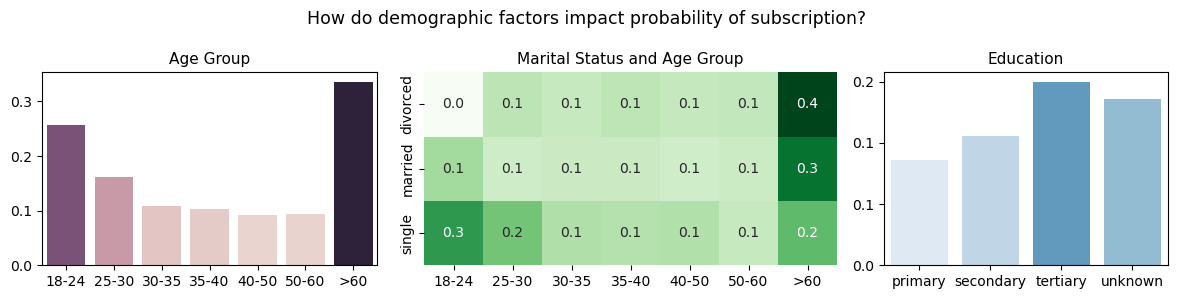

In [517]:
fig,axs = plt.subplots(figsize= (12,3), ncols= 3, width_ratios= [0.325, 0.4, 0.275])

sns.barplot(data.groupby('age_group')['y'].agg(calc_success_rate).reset_index(), x= "age_group", y= "y", ax= axs[0], 
            hue= "y", legend= False)
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title("Age Group", fontsize= 11)

sns.heatmap(pd.pivot_table(data= data, index= "marital",  columns= "age_group",values= 'y', aggfunc= calc_success_rate).\
            fillna(0), annot= True, cbar= False, cmap = sns.color_palette("Greens", as_cmap= True), fmt= "0.1f", ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title("Marital Status and Age Group", fontsize= 11)


sns.barplot(data.groupby('education')['y'].agg(calc_success_rate).reset_index(), x= "education", y= "y", ax= axs[2], 
            hue= "y", legend= False, palette= sns.color_palette('Blues'))
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_title("Education", fontsize= 11)

def format_func(value, tick_number):
    return f'{value:.1f}'

# Apply the format function to the y-axis
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# sns.heatmap(pd.pivot_table(data= data, index= "housing",  columns= "loan",values= 'y', aggfunc= calc_success_rate).\
#             fillna(0), annot= True, cbar= False, cmap = sns.color_palette("Blues", as_cmap= True), fmt= "0.2f", ax= axs[2])
# axs[2].set_title("Housing and Personal Loan?", fontsize= 11)

plt.suptitle("How do demographic factors impact probability of subscription?",
             fontsize= 12.5)
plt.tight_layout();

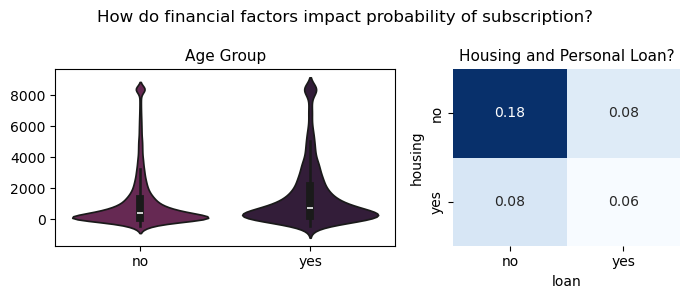

In [529]:
fig,axs = plt.subplots(figsize= (7,3), ncols= 2, width_ratios= [0.6, 0.4])

sns.violinplot(data= data, hue= "y", x= "y", y= "balance", palette= sns.color_palette("rocket"), ax= axs[0], hue_order= ['yes','no'])
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title("Age Group", fontsize= 11)

sns.heatmap(pd.pivot_table(data= data, index= "housing",  columns= "loan",values= 'y', aggfunc= calc_success_rate).\
            fillna(0), annot= True, cbar= False, cmap = sns.color_palette("Blues", as_cmap= True), fmt= "0.2f", ax= axs[1])
axs[1].set_title("Housing and Personal Loan?", fontsize= 11)

plt.suptitle("How do financial factors impact probability of subscription?",
             fontsize= 12)
plt.tight_layout();

## Modeling

### Feature Transfrom

In [4]:
cat_features= ['job', 'marital', 'education', 'contact', 'poutcome', 'month']
binary_features = ['default', 'housing', 'loan']
num_features = np.setdiff1d(data.columns, np.union1d(cat_features, binary_features)).tolist()
num_features.remove('y')
num_features.remove('duration')

target= 'y'
features = np.setdiff1d(data.columns, target).tolist()
features.remove('duration') # remove duration since nnot known before the call. does not influence targeting strategy.
data[target] = (data[target] == 'yes').astype(int)

data[binary_features] = (data[binary_features] == "yes").astype(int)
col_transform = ColumnTransformer([
    ('oe', OneHotEncoder(drop= 'if_binary', handle_unknown= 'ignore'), cat_features),
    ('poly', PolynomialFeatures(degree= 1), num_features)], remainder = 'passthrough')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], train_size= int(2e4), shuffle= True,
                                                    stratify= data[target], random_state= 0)

### Logistic Regression

In [9]:
# # load
# with open('logreg.pkl', 'rb') as f:
#     logreg_grid = pickle.load(f)
    
logreg_pipe = Pipeline([
    ('transform', col_transform),
    ('clf', LogisticRegression(penalty= 'l1', solver= 'liblinear'))
])

param_grid = {'clf__C': [1/(10**pp) for pp in range(-2,3)],'clf__penalty': ['l1','l2'], 'clf__class_weight': [None, 'balanced'],
              'transform__poly__degree': range(1,3)}
logreg_grid = GridSearchCV(logreg_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_logreg = logreg_grid.predict(X_test)

print(logreg_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Logistic Regression: {logreg_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Logistic Regression: {logreg_grid.score(X_test, y_test):0.2f}")

# save
with open('logreg.pkl','wb') as f:
    pickle.dump(logreg_grid,f)

{'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'transform__poly__degree': 2}
---------------------------------
Training F1-score for Logistic Regression: 0.40
Test F1-score for Logistic Regression: 0.39


### K-Nearest Neighbors

In [18]:
# # load
# with open('knn.pkl', 'rb') as f:
#     knn_grid = pickle.load(f)

knn_pipe = Pipeline([
    ('transform', col_transform),
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid = {'clf__n_neighbors': [3,5,10,20,50,100,200], 'clf__metric': ['minkowski', 'cosine'], 'clf__weights': ['uniform', 'distance'], 
              'transform__poly__degree': range(1,3)}
knn_grid = GridSearchCV(knn_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_knn = knn_grid.predict(X_test)

print(knn_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for KNN Classifier: {knn_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for KNN Classifier: {knn_grid.score(X_test, y_test):0.2f}")

# save
with open('knn.pkl','wb') as f:
    pickle.dump(knn_grid,f)

{'clf__metric': 'cosine', 'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'transform__poly__degree': 2}
---------------------------------
Training F1-score for KNN Classifier: 0.45
Test F1-score for KNN Classifier: 0.33


### Decision Tree Classifier

In [13]:
# # load
# with open('tree.pkl', 'rb') as f:
#     tree_grid = pickle.load(f)

tree_pipe = Pipeline([
    ('transform', col_transform),
    ('clf', DecisionTreeClassifier(random_state=0, criterion= 'entropy'))
])

param_grid = {'clf__max_depth': range(2,11,2), 'clf__min_samples_split': [2, 0.005, 0.01, 0.05, 0.1],
              'clf__criterion': ['gini', 'entropy'],
              'clf__class_weight': [None, 'balanced'],
              'transform__poly__degree': range(1,3)}
tree_grid = GridSearchCV(tree_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_tree = tree_grid.predict(X_test)

print(tree_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Tree Classifier: {tree_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Tree Classifier: {tree_grid.score(X_test, y_test):0.2f}")

# save
with open('tree.pkl','wb') as f:
    pickle.dump(tree_grid,f)

{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 0.1, 'transform__poly__degree': 1}
---------------------------------
Training F1-score for Tree Classifier: 0.44
Test F1-score for Tree Classifier: 0.43


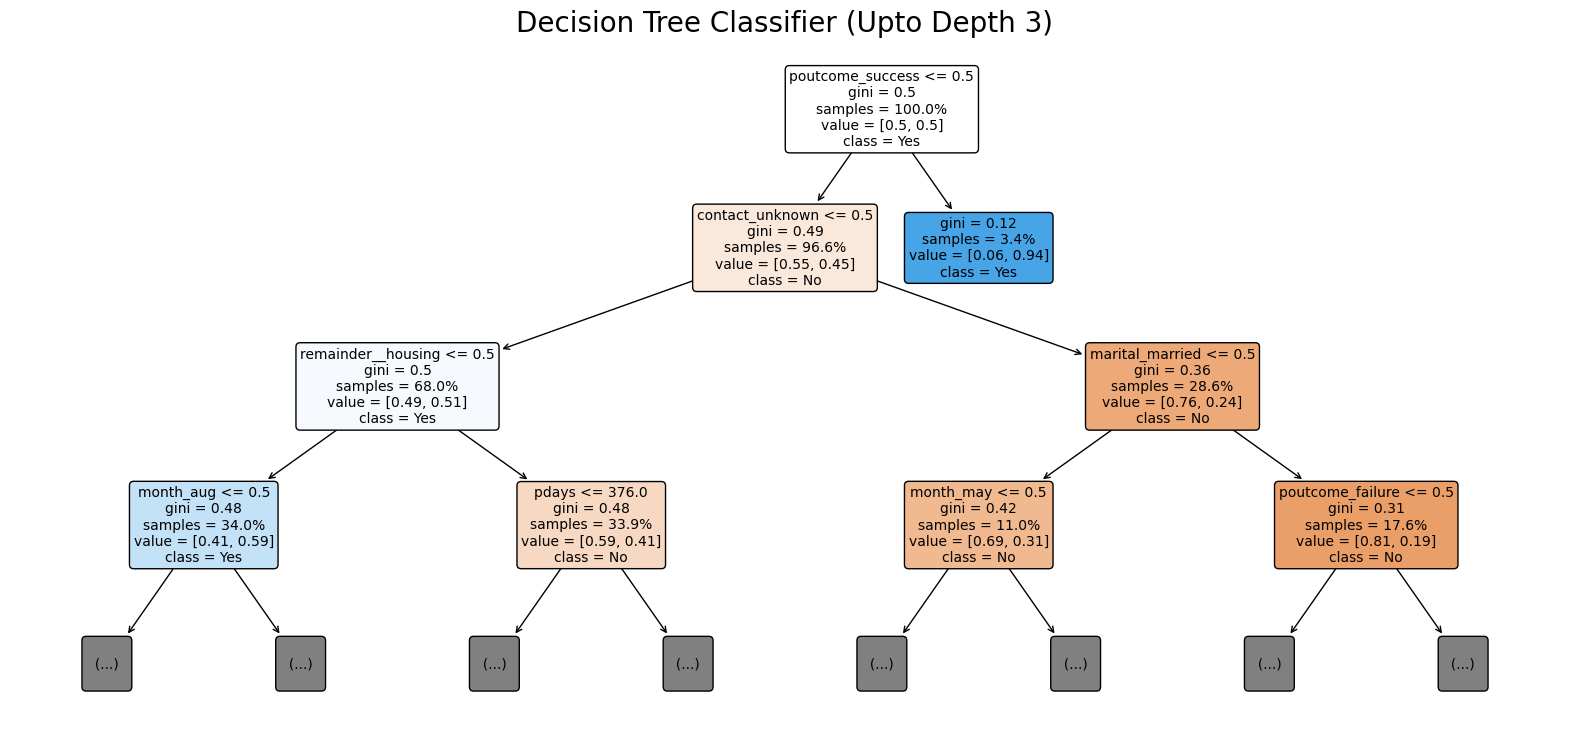

In [335]:
feature_names = tree_grid.best_estimator_[:-1].get_feature_names_out()
feature_names = [ss.replace('poly__','').replace('oe__','') for ss in feature_names]
plt.figure(figsize= (20,9))
plot_tree(tree_grid.best_estimator_[-1], feature_names= feature_names, rounded= True, class_names= ['No', 'Yes'],
           filled= True, max_depth= 3, fontsize= 10, precision= 2, proportion= True);
plt.title("Decision Tree Classifier (Upto Depth 3)", fontsize= 20);
plt.savefig("images/tree.png")

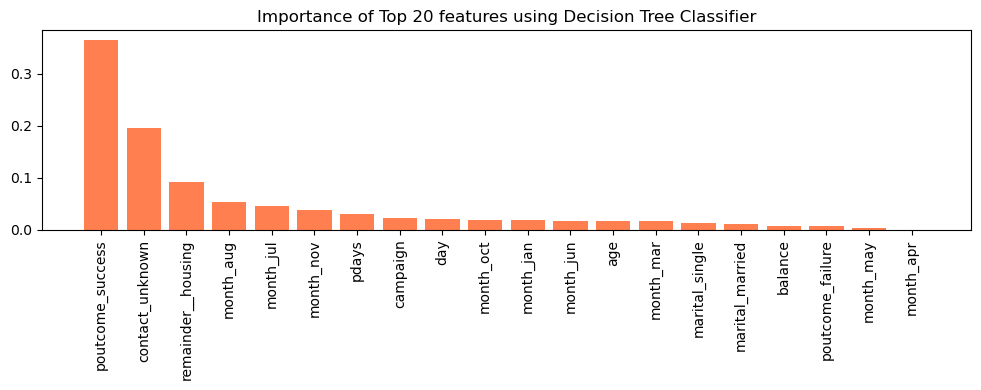

In [338]:
df_imp = pd.DataFrame(tree_grid.best_estimator_[-1].feature_importances_, index= feature_names, columns= ['importance'])
df_imp.sort_values('importance', ascending= False, inplace= True)

plt.figure(figsize= (10,4))
plt.bar(df_imp.head(20).index, df_imp.head(20)['importance'], color= 'coral')
plt.xticks(rotation= 90);
plt.title("Importance of Top 20 features using Decision Tree Classifier");
plt.tight_layout();
plt.savefig("images/tree_feature_importance.png")

### Support Vector Machine

In [22]:
# load
# with open('svm.pkl', 'rb') as f:
#     svm_grid = pickle.load(f)

svm_pipe = Pipeline([
    ('transform', col_transform),
    ('selector', RFE(LogisticRegression(), n_features_to_select= 25)),
    ('clf', BaggingClassifier(estimator=SVC(), max_samples= 500, n_estimators= 10))
    # ('clf', SVC())
])

param_grid = {'clf__estimator__kernel': ['linear', 'rbf', 'sigmoid']}
svm_grid = GridSearchCV(svm_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train.head(1000), y_train.head(1000))

y_pred_svm = svm_grid.predict(X_test)

print(svm_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for SVM: {svm_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for SVM: {svm_grid.score(X_test, y_test):0.2f}")

# save
with open('svm.pkl','wb') as f:
    pickle.dump(svm_grid,f)

{'clf__estimator__kernel': 'linear'}
---------------------------------
Training F1-score for SVM: 0.30
Test F1-score for SVM: 0.28


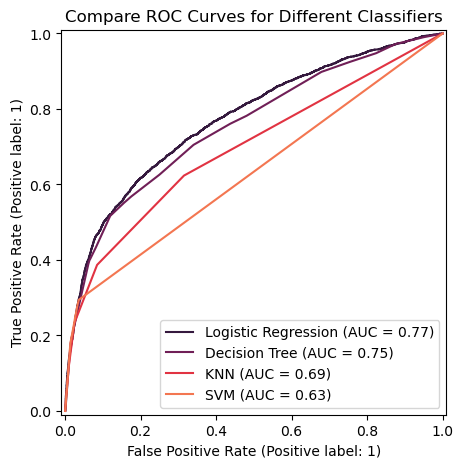

In [333]:
colors = sns.color_palette('rocket')

fig,ax = plt.subplots(figsize= (6,5))
RocCurveDisplay.from_estimator(logreg_grid, X_test, y_test, name= "Logistic Regression", ax= ax, color= colors[0])
RocCurveDisplay.from_estimator(tree_grid, X_test, y_test, name= "Decision Tree", ax= ax, color= colors[1])
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, name= "KNN", ax= ax, color= colors[3])
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, name= "SVM", ax= ax, color= colors[4])


ax.set_title("Compare ROC Curves for Different Classifiers", fontsize= 12);
fig.savefig("images/roc_curves_all.png")

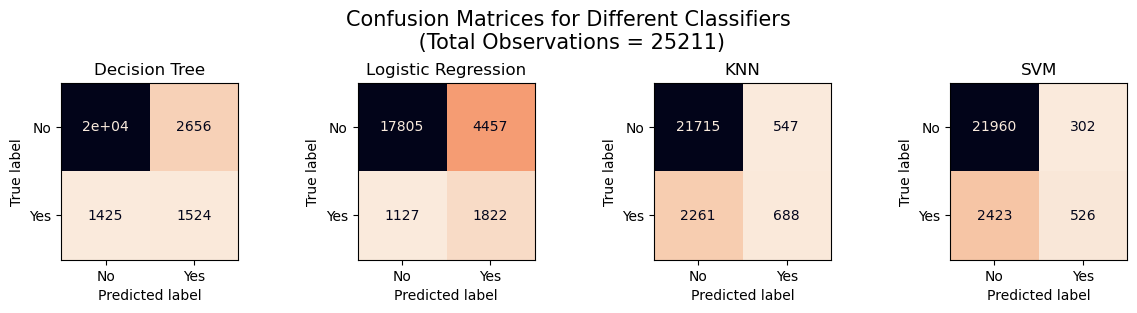

In [334]:
fig, axs = plt.subplots(figsize= (12,3), ncols= 4)

ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test, ax= axs[0], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[0].set_title("Decision Tree")
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test, y_test, ax= axs[1], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[1].set_title("Logistic Regression")
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test, ax= axs[2], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[2].set_title("KNN")
ConfusionMatrixDisplay.from_estimator(svm_grid, X_test, y_test, ax= axs[3], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[3].set_title("SVM")

plt.suptitle(f"Confusion Matrices for Different Classifiers\n (Total Observations = {X_test.shape[0]})", fontsize= 15)
plt.tight_layout();
fig.savefig("images/confusion_matrices_all.png")